In [1]:
import torchvision
from torchvision import models
from torchvision.transforms import transforms
import torch
import CitiesData
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time

In [3]:
# The inference transforms are available at ViT_B_16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
# The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. 
# Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

#models.ViT_B_16_Weights.IMAGENET1K_V1
model_name = "Inception_from_scratch"
model_image_size = 224

In [2]:
class CityInception(torch.nn.Module):
    def __init__(self, numClasses: int, softmax:bool = True):
        super(CityInception, self).__init__()

        self.inceptionBase = torchvision.models.inception_v3(weights='DEFAULT')
        self.inceptionBase.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 216),
            torch.nn.ReLU(),
            torch.nn.Linear(216, 10)
        )
        for param in list(self.inceptionBase.parameters())[:-1]:
            param.requires_grad = False
        # for param in self.inceptionBase.parameters():
        #     print(param.requires_grad)

        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        # print(x.shape)
        logits = self.inceptionBase(x)
        # print(type(logits))
        # print(logits)
        # print(logits.shape)
        probs = self.softmax(logits.logits)

        return probs






In [11]:
model = CityInception(10).to(device)
print(*list(model.children())[:-1])

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [5]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
batch_size = 32
transform = transforms.Compose([
    transforms.Resize(342),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
trainDataLoader, validDataLoader, testDataLoader = CitiesData.getCitiesDataLoader("./Data/", transforms = transform, batchSize=batch_size)

In [7]:
print(len(trainDataLoader))
print(len(validDataLoader))
print(len(testDataLoader))
for i in trainDataLoader:
    image, cities, _, _ = i
    print(image.shape)
    break

6258
696
torch.Size([32, 3, 224, 224])


In [8]:
from fvcore.nn import FlopCountAnalysis
valid_image = 0
for i in validDataLoader:
    valid_image, cities, _, _ = i
    valid_image = valid_image.to(device)
    break
flops = FlopCountAnalysis(model, valid_image)
print(str(flops.total()) + " flops")
# Ignore Reds

Unsupported operator aten::mul encountered 49 time(s)
Unsupported operator aten::add encountered 25 time(s)
Unsupported operator aten::div encountered 12 time(s)
Unsupported operator aten::unflatten encountered 12 time(s)
Unsupported operator aten::scaled_dot_product_attention encountered 12 time(s)
Unsupported operator aten::gelu encountered 12 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
reference_vit.encoder.layers.encoder_layer_0.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_1.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_10.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_11.self_att

539732877312 flops


In [9]:
def evaluate_on_data(vit, dataloader):
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        total_loss = 0
        
        num_correct = 0.0
        num_samples = 0.0
        for data in dataloader:
            image, city, _, _ = data
            city = city.to(device)
            image = image.to(device)
            outputs = vit(image)
            loss = criterion(outputs, city)
            total_loss += loss.item()
            for i in range(len(city)):

                model_vote = 0
                answer = 0
                for j in range(len(outputs[i])):
                    if outputs[i][j] > outputs[i][model_vote]:
                        model_vote = j
                    if city[i][j] == 1:
                        answer = j
                
                if answer == model_vote:
                    num_correct += 1
                num_samples += 1
                    
                
                
    return total_loss / len(dataloader), num_correct / num_samples

In [3]:
num_epochs = 10
count = 0
valid_loss_array = []
valid_acc_array = []
train_loss_array = []
for epoch in range(num_epochs):
    start = time.time()
    temp = 0
    for data in trainDataLoader:
        
        image, city, _, _ = data
        
        city = city.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, city)
        loss.backward()
        optimizer.step()
        
        end = time.time()
        count += 1
        print(str(int(end-start)) + " sec " + str(count * batch_size) + " images " + str(loss.item()) + " loss", end='\x1b\r')

    valid_loss, valid_acc = evaluate_on_data(model, validDataLoader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}')
    valid_loss_array.append(valid_loss)
    train_loss_array.append(loss.item())
    valid_acc_array.append(valid_acc)

Epoch [1/50], Training Loss: 2.0697031021118164, Valid Loss: 2.168548546884475, Valid ACC: 0.3068318018377946
Epoch [2/50], Training Loss: 1.921957860822263, Valid Loss: 2.0991763649075956, Valid ACC: 0.37135437475029964
Epoch [3/50], Training Loss: 2.1143373717432437, Valid Loss: 2.069381692443442, Valid ACC: 0.3931282461046744
Epoch [4/50], Training Loss: 2.0942250904829605, Valid Loss: 2.0594251018616236, Valid ACC: 0.4055133839392729
Epoch [5/50], Training Loss: 2.244804719220037, Valid Loss: 2.0509766071802007, Valid ACC: 0.41230523371953653
Epoch [6/50], Training Loss: 2.1085853835810786, Valid Loss: 2.0465439719779948, Valid ACC: 0.4159009188973232
Epoch [7/50], Training Loss: 2.0813864003057065, Valid Loss: 2.0333048184768163, Valid ACC: 0.4282860567319217
Epoch [8/50], Training Loss: 1.966767150422801, Valid Loss: 2.028132677038333, Valid ACC: 0.4340791050739113
Epoch [9/50], Training Loss: 2.0190545838812124, Valid Loss: 2.0191874851505935, Valid ACC: 0.43867359168997205
Epoc

In [ ]:
with open(model_name + '_valid.npy', 'wb') as f:
    np.save(f, valid_loss_array)
    
with open(model_name + '_valid_acc.npy', 'wb') as f:
    np.save(f, valid_acc_array)
    
with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)

In [4]:
valid_loss_array

array([2.16264544, 2.1026912 , 2.07158134, 2.05758711, 2.04791151,
       2.03892329, 2.03831787, 2.03083876, 2.02341355, 2.02522501,
       2.01811093, 2.02071296, 2.01465933, 2.01838953, 2.00805128,
       2.00595369, 2.01043024, 2.01023636, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

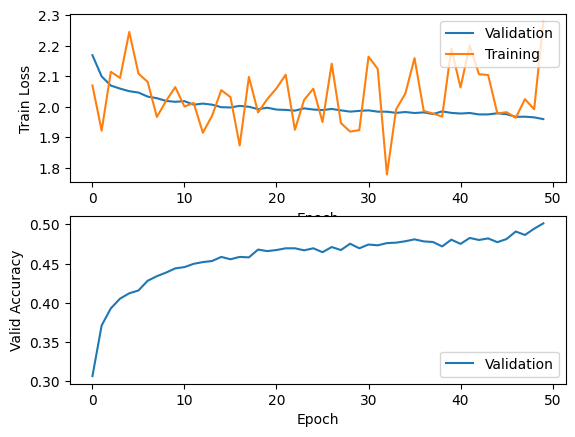

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)
# this locator puts ticks at regular intervals

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Valid Cross Entropy")
ax[0].plot(range(len(valid_loss_array)), valid_loss_array, label="Validation")

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Valid Accuracy")
ax[1].plot(range(len(valid_acc_array)),valid_acc_array, label="Validation")

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Train Loss")
ax[0].plot(range(len(train_loss_array)), train_loss_array, label="Training")

ax[0].legend(loc="upper right")
ax[1].legend(loc="lower right")


In [6]:
test_loss, test_acc = evaluate_on_data(model, validDataLoader)
print(f"Test Loss: {test_loss}, Test ACC: {test_acc}")

Test Loss: 1.9571382257919414, Test ACC: 0.502247393024092
